# Setup

In [1]:
# import libraries
import os
import sys
import time
import pandas as pd
import numpy as np
from scipy import stats
from scipy.interpolate import CubicSpline
import torch.optim as optim
import torch.nn as nn
import torch
from torch.optim import Adam
from scipy.fftpack import fft, ifft
from scipy.stats import mode

## Hyperparameter

In [2]:
num_epochs = 200
batch_size = 64  # Set your batch size
learning_rate = 0.001

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
# set the seed
torch.manual_seed(420)
np.random.seed(420)


# Data Loading

## HHAR

In [4]:
# load data
# data = pd.read_csv('./ISWC21_data_plus_raw/hhar_data.csv', header=None)
data_hhar = pd.read_csv('./ISWC21_data_plus_raw/raw/hhar/Watch_accelerometer.csv')
#add header
# data.columns = ['subject_id', 'acc_x', 'acc_y', 'acc_z', 'activity']

# sort data by creation_time
data_hhar = data_hhar.sort_values(by=['Creation_Time'])
data_hhar

,Index,Arrival_Time,Creation_Time,x,y,z,User,Model,Device,gt
3179488,0,1424686740286,202601646000,4.018668,-7.155670,-3.341109,g,gear,gear_2,stand
3179489,1,1424686740287,202609390000,3.605069,-6.991668,-3.151368,g,gear,gear_2,stand
3179490,2,1424686740287,202619269000,3.038841,-6.546346,-3.436278,g,gear,gear_2,stand
3179491,3,1424686740287,202631619000,3.030461,-6.183026,-2.860472,g,gear,gear_2,stand
3179492,4,1424686740287,202639113000,3.354875,-6.126762,-2.382231,g,gear,gear_2,stand
...,...,...,...,...,...,...,...,...,...,...
2457915,459441,1424789460608,300643618732647,7.858872,3.448090,7.490219,e,lgwatch,lgwatch_1,bike
2457916,459442,1424789460612,300643623676495,7.478012,3.455231,6.997482,e,lgwatch,lgwatch_1,bike
2457917,459443,1424789460618,300643628711895,7.516098,2.324554,6.661850,e,lgwatch,lgwatch_1,bike
2457918,459444,1424789460622,300643633625225,6.811508,2.072235,6.885605,e,lgwatch,lgwatch_1,bike


In [5]:
# print number of unique subjects
print(data_hhar['User'].nunique())

9


### Data Preprocessed

In [6]:
# drop columns
data_hhar = data_hhar.drop(columns=['Index', 'Arrival_Time', 'Creation_Time', 'Model', 'Device'])
data_hhar

,x,y,z,User,gt
3179488,4.018668,-7.155670,-3.341109,g,stand
3179489,3.605069,-6.991668,-3.151368,g,stand
3179490,3.038841,-6.546346,-3.436278,g,stand
3179491,3.030461,-6.183026,-2.860472,g,stand
3179492,3.354875,-6.126762,-2.382231,g,stand
...,...,...,...,...,...
2457915,7.858872,3.448090,7.490219,e,bike
2457916,7.478012,3.455231,6.997482,e,bike
2457917,7.516098,2.324554,6.661850,e,bike
2457918,6.811508,2.072235,6.885605,e,bike


In [7]:
# replace user id with a number
user_dict = {
        'a': 0,
        'b': 1,
        'c': 2,
        'd': 3,
        'e': 4,
        'f': 5,
        'g': 6,
        'h': 7,
        'i': 8,
}
data_hhar = data_hhar.replace({"User": user_dict})

In [8]:
# replace activity with a number
activity_dict = {
        'bike': 1,
        'sit': 2,
        'stand': 3,
        'walk': 4,
        'stairsup': 5,
        'stairsdown': 6,
}
data_hhar = data_hhar.replace({"gt": activity_dict})

In [9]:
# print(data_hhar['gt'].value_counts())

In [10]:
# print(data_hhar['User'].value_counts())

In [11]:
data_hhar

,x,y,z,User,gt
3179488,4.018668,-7.155670,-3.341109,6,3.0
3179489,3.605069,-6.991668,-3.151368,6,3.0
3179490,3.038841,-6.546346,-3.436278,6,3.0
3179491,3.030461,-6.183026,-2.860472,6,3.0
3179492,3.354875,-6.126762,-2.382231,6,3.0
...,...,...,...,...,...
2457915,7.858872,3.448090,7.490219,4,1.0
2457916,7.478012,3.455231,6.997482,4,1.0
2457917,7.516098,2.324554,6.661850,4,1.0
2457918,6.811508,2.072235,6.885605,4,1.0


In [12]:
# resample data to 50 hz from 100 hz
data_hhar = data_hhar.iloc[::2, :]

In [13]:
# reorder columns
data_hhar = data_hhar[['User', 'x', 'y', 'z', 'gt']]

In [14]:
# rename the columns name
data_hhar.columns = ['subject_id', 'acc_x', 'acc_y', 'acc_z', 'activity']

In [15]:
data_hhar

,subject_id,acc_x,acc_y,acc_z,activity
3179488,6,4.018668,-7.155670,-3.341109,3.0
3179490,6,3.038841,-6.546346,-3.436278,3.0
3179492,6,3.354875,-6.126762,-2.382231,3.0
3179494,6,2.688689,-5.518635,-1.930924,3.0
3179498,6,0.672172,-4.964377,-1.953669,3.0
...,...,...,...,...,...
2457910,4,6.751999,1.558075,7.064133,1.0
2457912,4,7.835068,2.555450,8.770859,1.0
2457914,4,8.118332,3.052948,8.444748,1.0
2457916,4,7.478012,3.455231,6.997482,1.0


In [16]:
# check for missing values
data_hhar.isnull().sum()

subject_id         0
acc_x              0
acc_y              0
acc_z              0
activity      260235
dtype: int64

In [17]:
# drop missing values
data_hhar = data_hhar.dropna()

In [18]:
print(data_hhar['subject_id'].unique())

[6 5 7 3 2 1 0 4 8]


## RealWorld

In [19]:
# load data without header
data_rwhar = pd.read_csv('./ISWC21_data_plus_raw/rwhar_data.csv', header=None)
# add header
data_rwhar.columns = ['subject_id', 'acc_x', 'acc_y', 'acc_z', 'activity']
data_rwhar

,subject_id,acc_x,acc_y,acc_z,activity
0,0,-9.57434,-2.02733,1.34506,climbing_up
1,0,-9.56479,-1.99597,1.39345,climbing_up
2,0,-9.55122,-1.98445,1.41139,climbing_up
3,0,-9.51335,-1.97557,1.42615,climbing_up
4,0,-9.52959,-1.98187,1.45395,climbing_up
...,...,...,...,...,...
3200798,14,-9.28186,-2.45740,-1.88879,lying
3200799,14,-9.28955,-2.59154,-1.90494,lying
3200800,14,-9.31358,-2.62135,-1.90950,lying
3200801,14,-9.26154,-2.64308,-1.93750,lying


In [20]:
# print count of unique subjects
print(data_rwhar['subject_id'].nunique())

15


In [21]:
# print count of unique activities
print(data_rwhar['activity'].nunique())

8


### Data Preprocessed

In [22]:
#check for missing values
data_rwhar.isnull().sum()

subject_id    0
acc_x         0
acc_y         0
acc_z         0
activity      0
dtype: int64

In [23]:
data_rwhar['subject_id'] = data_rwhar['subject_id'] + 9

In [24]:
print(data_rwhar['subject_id'].unique())

[ 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]


In [25]:
# replace activity with a number
activity_dict = {
        'climbing_down': 6,
        'climbing_up': 5,
        'jumping': 7,
        'lying': 8,
        'running': 9,
        'sitting': 2,
        'standing': 3,
        'walking': 4,
}
data_rwhar = data_rwhar.replace({"activity": activity_dict})

In [26]:
print(data_rwhar['activity'].value_counts())

activity
9    522013
4    482938
8    479455
2    478761
3    473147
5    371180
6    320302
7     73007
Name: count, dtype: int64


In [27]:
print(data_rwhar['subject_id'].value_counts())

subject_id
13    245822
16    243823
11    227821
17    224449
23    222116
19    220262
21    218636
14    215920
9     214659
20    212453
18    210260
12    207492
15    189243
22    179282
10    168565
Name: count, dtype: int64


In [28]:
data_rwhar

,subject_id,acc_x,acc_y,acc_z,activity
0,9,-9.57434,-2.02733,1.34506,5
1,9,-9.56479,-1.99597,1.39345,5
2,9,-9.55122,-1.98445,1.41139,5
3,9,-9.51335,-1.97557,1.42615,5
4,9,-9.52959,-1.98187,1.45395,5
...,...,...,...,...,...
3200798,23,-9.28186,-2.45740,-1.88879,8
3200799,23,-9.28955,-2.59154,-1.90494,8
3200800,23,-9.31358,-2.62135,-1.90950,8
3200801,23,-9.26154,-2.64308,-1.93750,8


## SBHAR

In [29]:
#load dataset without header
data_sbhar = pd.read_csv('./ISWC21_data_plus_raw/sbhar_data.csv', header=None)
# add header
data_sbhar.columns = ['subject_id', 'acc_x', 'acc_y', 'acc_z', 'activity']
data_sbhar

,subject_id,acc_x,acc_y,acc_z,activity
0,0,0.443056,0.037500,0.888889,null_class
1,0,0.440278,0.041667,0.880556,null_class
2,0,0.451389,0.043056,0.876389,null_class
3,0,0.456944,0.034722,0.888889,null_class
4,0,0.447222,0.036111,0.888889,null_class
...,...,...,...,...,...
1122767,29,0.430556,0.501389,0.923611,null_class
1122768,29,0.430556,0.501389,0.923611,null_class
1122769,29,0.473611,0.493056,0.906944,null_class
1122770,29,0.472222,0.502778,0.884722,null_class


### Data Preprocessed

In [30]:
# drop activity with 'null_class'
data_sbhar = data_sbhar[data_sbhar['activity'] != 'null_class']

In [31]:
data_sbhar

,subject_id,acc_x,acc_y,acc_z,activity
251,0,0.990278,-0.337500,0.022222,standing
252,0,0.986111,-0.340278,0.012500,standing
253,0,0.987500,-0.333333,0.011111,standing
254,0,0.988889,-0.327778,0.012500,standing
255,0,0.986111,-0.333333,0.009722,standing
...,...,...,...,...,...
1121783,29,0.880556,-0.390278,-0.156944,walking_upstairs
1121784,29,0.834722,-0.358333,-0.098611,walking_upstairs
1121785,29,0.802778,-0.329167,-0.104167,walking_upstairs
1121786,29,0.770833,-0.287500,-0.098611,walking_upstairs


In [32]:
# check for missing values
data_sbhar.isnull().sum()

subject_id    0
acc_x         0
acc_y         0
acc_z         0
activity      0
dtype: int64

In [33]:
# print count of unique subjects
print(data_sbhar['subject_id'].nunique())

30


In [34]:
# print count of unique activities
print(data_sbhar['activity'].nunique())

12


In [35]:
# change subject_id number
data_sbhar['subject_id'] = data_sbhar['subject_id'] + 24

C:\Users\IME-LAB\AppData\Local\Temp\ipykernel_11240\233390806.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sbhar['subject_id'] = data_sbhar['subject_id'] + 24


In [36]:
print(data_sbhar['subject_id'].unique())

[24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53]


In [37]:
data_sbhar['activity'].value_counts()

activity
standing              138105
lying                 136865
sitting               126677
walking               122091
walking_upstairs      116707
walking_downstairs    107961
stand-to-lie           14418
sit-to-lie             12428
lie-to-sit             11150
lie-to-stand           10867
stand-to-sit           10316
sit-to-stand            8029
Name: count, dtype: int64

In [38]:
# replace activity with a number
activity_dict = {
        'walking': 4,
        'walking_upstairs': 5,
        'walking_downstairs': 6,
        'sitting': 2,
        'standing': 3,
        'lying': 8,
        'stand-to-sit': 10,
        'sit-to-stand': 11,
        'sit-to-lie': 12,
        'lie-to-sit': 13,
        'stand-to-lie': 14,
        'lie-to-stand': 15,
}
data_sbhar = data_sbhar.replace({"activity": activity_dict})

In [39]:
print(data_sbhar['activity'].unique())

[ 3 10  2 11 14  8 13 12 15  4  6  5]


In [40]:
data_sbhar['activity'].value_counts()

activity
3     138105
8     136865
2     126677
4     122091
5     116707
6     107961
14     14418
12     12428
13     11150
15     10867
10     10316
11      8029
Name: count, dtype: int64

## Data Merging

In [41]:
# merge all datasets
data = pd.concat([data_hhar, data_rwhar, data_sbhar], ignore_index=True)
data

,subject_id,acc_x,acc_y,acc_z,activity
0,6,4.018668,-7.155670,-3.341109,3.0
1,6,3.038841,-6.546346,-3.436278,3.0
2,6,3.354875,-6.126762,-2.382231,3.0
3,6,2.688689,-5.518635,-1.930924,3.0
4,6,0.672172,-4.964377,-1.953669,3.0
...,...,...,...,...,...
5526658,53,0.880556,-0.390278,-0.156944,5.0
5526659,53,0.834722,-0.358333,-0.098611,5.0
5526660,53,0.802778,-0.329167,-0.104167,5.0
5526661,53,0.770833,-0.287500,-0.098611,5.0


In [42]:
#check for missing values
data.isnull().sum()

subject_id    0
acc_x         0
acc_y         0
acc_z         0
activity      0
dtype: int64

In [43]:
# check for unique subjects
print(data['subject_id'].nunique())

54


In [44]:
# print all of the unique subjects and sort them from smallest to largest
print(np.sort(data['subject_id'].unique()))

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53]


In [45]:
# check for unique activities
print(data['activity'].nunique())

15


In [46]:
# print all of the unique activities and sort them from smallest to largest
print(np.sort(data['activity'].unique()))

[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15.]


In [47]:
# print the count of each activity
print(data['activity'].value_counts())

activity
4.0     883129
3.0     837286
2.0     817452
5.0     723433
6.0     668425
8.0     616320
9.0     522013
1.0     318390
7.0      73007
14.0     14418
12.0     12428
13.0     11150
15.0     10867
10.0     10316
11.0      8029
Name: count, dtype: int64


In [48]:
print(data['subject_id'].value_counts())

subject_id
4     250308
13    245822
16    243823
5     240547
11    227821
2     224969
17    224449
0     223778
23    222116
19    220262
21    218636
14    215920
9     214659
20    212453
1     212280
18    210260
12    207492
3     200172
15    189243
22    179282
10    168565
7      62399
6      59116
8      36677
44     31604
48     31528
47     30136
49     30097
53     30090
41     29625
40     29531
50     29265
46     28764
51     28745
43     28476
42     28116
39     28014
24     27905
52     27183
26     27047
38     26219
36     26161
37     25942
35     25762
29     25681
45     25512
27     25392
34     25290
25     24664
28     24648
30     24088
32     23834
33     23419
31     22876
Name: count, dtype: int64


# Data Preprocess

In [49]:
# # channel-wise z-normalization
# data['acc_x'] = (data['acc_x'] - data['acc_x'].mean()) / data['acc_x'].std()
# data['acc_y'] = (data['acc_y'] - data['acc_y'].mean()) / data['acc_y'].std()
# data['acc_z'] = (data['acc_z'] - data['acc_z'].mean()) / data['acc_z'].std()

<Axes: xlabel='activity_label'>

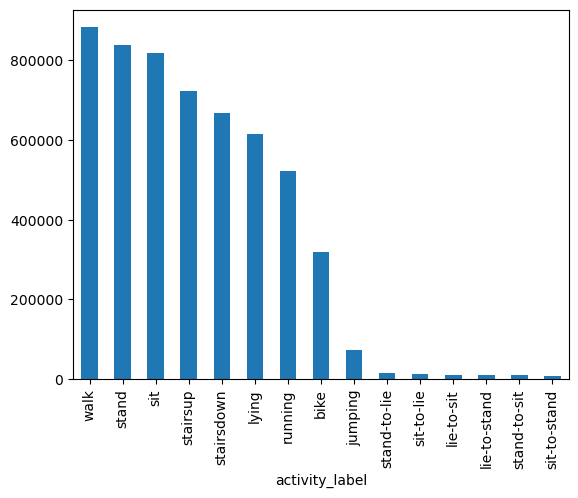

In [50]:
# label dictionary
label_dict = {
        1: 'bike',
        2: 'sit',
        3: 'stand',
        4: 'walk',
        5: 'stairsup',
        6: 'stairsdown',
        7: 'jumping',
        8: 'lying',
        9: 'running',
        10: 'stand-to-sit',
        11: 'sit-to-stand',
        12: 'sit-to-lie',
        13: 'lie-to-sit',
        14: 'stand-to-lie',
        15: 'lie-to-stand',
}

# visualize the label distribution using label dictionary
data['activity_label'] = data['activity'].map(label_dict)
data['activity_label'].value_counts().plot(kind='bar')

<Axes: xlabel='subject_id'>

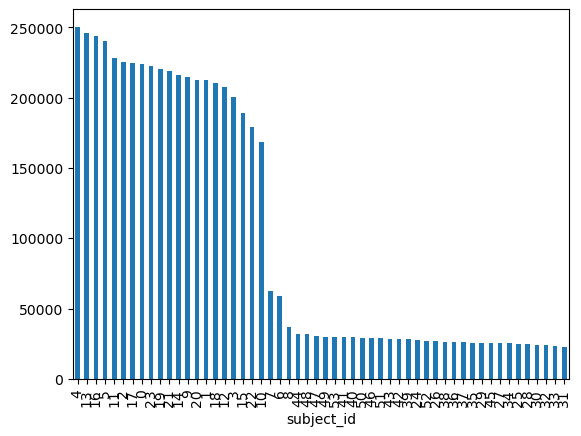

In [51]:
# visualize the subject distribution
data['subject_id'].value_counts().plot(kind='bar')

In [52]:
#drop activity_label
data = data.drop(columns=['activity_label'])

In [53]:
data

,subject_id,acc_x,acc_y,acc_z,activity
0,6,4.018668,-7.155670,-3.341109,3.0
1,6,3.038841,-6.546346,-3.436278,3.0
2,6,3.354875,-6.126762,-2.382231,3.0
3,6,2.688689,-5.518635,-1.930924,3.0
4,6,0.672172,-4.964377,-1.953669,3.0
...,...,...,...,...,...
5526658,53,0.880556,-0.390278,-0.156944,5.0
5526659,53,0.834722,-0.358333,-0.098611,5.0
5526660,53,0.802778,-0.329167,-0.104167,5.0
5526661,53,0.770833,-0.287500,-0.098611,5.0


## Partitioned the Data for Train and Test

In [54]:
# disabiling the warnings
import warnings
warnings.filterwarnings("ignore")

In [55]:
# data_test = {}
# data_labelled_train = {}
# data_unlabelled_train = {}

# #split the data for each subject
# for subject in np.sort(data['subject_id'].unique()):
#     subject_data = data[data['subject_id'] == subject]
#     # Shuffle the subject data
#     subject_data = subject_data.sample(frac=1).reset_index(drop=True)

#     # drop the subject_id column
#     subject_data = subject_data.drop(columns=['subject_id'])

#     # Split the subject data into 80% training and 20% testing
#     train, test = np.split(subject_data, [int(0.8 * len(subject_data))])

#     # Within the train data, further split into 20% labelled and 80% unlabelled
#     labelled_train, unlabelled_train = np.split(train, [int(0.2 * len(train))])

#     data_test[subject] = test
#     data_labelled_train[subject] = labelled_train
#     data_unlabelled_train[subject] = unlabelled_train

# # verify the split
# for subject in np.sort(data['subject_id'].unique()):
#     print('Subject:', subject)
#     print('Test:', data_test[subject].shape)
#     print('Labelled Train:', data_labelled_train[subject].shape)
#     print('Unlabelled Train:', data_unlabelled_train[subject].shape)

In [56]:
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np

data_test = {}
data_labelled_train = {}
data_unlabelled_train = {}

# Initialize StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for subject in np.sort(data['subject_id'].unique()):
    subject_data = data[data['subject_id'] == subject]
    labels = subject_data['activity'].values  # Assuming 'label' is your class label column

    # Drop the subject_id column
    subject_data = subject_data.drop(columns=['subject_id'])
    
    # Perform stratified split for train and test
    for train_index, test_index in sss.split(subject_data, labels):
        train_data, test_data = subject_data.iloc[train_index], subject_data.iloc[test_index]
        train_labels = labels[train_index]
        
        # Further split train data into labelled and unlabelled in a stratified manner
        sss_inner = StratifiedShuffleSplit(n_splits=1, test_size=0.8, random_state=42)
        for labelled_index, unlabelled_index in sss_inner.split(train_data, train_labels):
            labelled_train_data, unlabelled_train_data = train_data.iloc[labelled_index], train_data.iloc[unlabelled_index]
    
    # Store splits
    data_test[subject] = test_data
    data_labelled_train[subject] = labelled_train_data
    data_unlabelled_train[subject] = unlabelled_train_data

# Verify the split
for subject in np.sort(data['subject_id'].unique()):
    print('Subject:', subject)
    print('Test:', data_test[subject].shape)
    print('Labelled Train:', data_labelled_train[subject].shape)
    print('Unlabelled Train:', data_unlabelled_train[subject].shape)

Subject: 0
Test: (44756, 4)
Labelled Train: (35804, 4)
Unlabelled Train: (143218, 4)
Subject: 1
Test: (42456, 4)
Labelled Train: (33964, 4)
Unlabelled Train: (135860, 4)
Subject: 2
Test: (44994, 4)
Labelled Train: (35995, 4)
Unlabelled Train: (143980, 4)
Subject: 3
Test: (40035, 4)
Labelled Train: (32027, 4)
Unlabelled Train: (128110, 4)
Subject: 4
Test: (50062, 4)
Labelled Train: (40049, 4)
Unlabelled Train: (160197, 4)
Subject: 5
Test: (48110, 4)
Labelled Train: (38487, 4)
Unlabelled Train: (153950, 4)
Subject: 6
Test: (11824, 4)
Labelled Train: (9458, 4)
Unlabelled Train: (37834, 4)
Subject: 7
Test: (12480, 4)
Labelled Train: (9983, 4)
Unlabelled Train: (39936, 4)
Subject: 8
Test: (7336, 4)
Labelled Train: (5868, 4)
Unlabelled Train: (23473, 4)
Subject: 9
Test: (42932, 4)
Labelled Train: (34345, 4)
Unlabelled Train: (137382, 4)
Subject: 10
Test: (33713, 4)
Labelled Train: (26970, 4)
Unlabelled Train: (107882, 4)
Subject: 11
Test: (45565, 4)
Labelled Train: (36451, 4)
Unlabelled Trai

## Channel-Wise Z-Normalization

In [57]:
def z_normalize_using_combined_stats(labelled_df, unlabelled_df, test_df, features=['acc_x', 'acc_y', 'acc_z']):
    # Combine labelled and unlabelled data to calculate statistics
    combined_df = pd.concat([labelled_df, unlabelled_df])
    
    # Calculate mean and std for each feature
    stats = {feature: (combined_df[feature].mean(), combined_df[feature].std()) for feature in features}
    
    # Function to apply normalization
    def apply_normalization(df):
        for feature in features:
            mean, std = stats[feature]
            df[feature] = (df[feature] - mean) / std
        return df

    # Normalize labelled, unlabelled, and test data using these statistics
    labelled_df = apply_normalization(labelled_df)
    unlabelled_df = apply_normalization(unlabelled_df)
    test_df = apply_normalization(test_df)

    return labelled_df, unlabelled_df, test_df

# Assuming you have dictionaries: data_labelled_train, data_unlabelled_train, and data_test
# Iterate over each client and apply the normalization
for subject in np.sort(data['subject_id'].unique()):
    data_labelled_train[subject], data_unlabelled_train[subject], data_test[subject] = z_normalize_using_combined_stats(
        data_labelled_train[subject],
        data_unlabelled_train[subject],
        data_test[subject]
    )

## Windowing the Data

In [58]:
def sliding_window_samples(data, samples_per_window, overlap_ratio):
    """
    Return a sliding window measured in number of samples over a data array along with the mode label for each window.

    :param data: input array, can be numpy or pandas dataframe
    :param samples_per_window: window length as number of samples
    :param overlap_ratio: overlap is meant as percentage and should be an integer value
    :return: tuple of windows, indices, and labels
    """
    windows = []
    indices = []
    labels = []
    curr = 0
    win_len = int(samples_per_window)
    if overlap_ratio is not None:
        overlapping_elements = int((overlap_ratio / 100) * win_len)
        if overlapping_elements >= win_len:
            print('Number of overlapping elements exceeds window size.')
            return
    while curr < len(data) - win_len:
        window = data[curr:curr + win_len]
        windows.append(window.iloc[:, :-1])  # Exclude the last column which is the label
        indices.append([curr, curr + win_len])
        
        # Extract and compute the mode of the encoded labels for the current window
        window_labels = window['activity']
        mode_result = mode(window_labels)
        window_label = mode_result[0] if mode_result[0].size > 0 else mode_result
        labels.append(window_label)

        curr += win_len - overlapping_elements

    result_windows = np.array(windows)
    result_indices = np.array(indices)
    result_labels = np.array(labels)
    return result_windows, result_indices, result_labels

In [59]:
# windowing the data for each subject
sampling_rate = 50
time_window = 2.56
window_size = sampling_rate * time_window
overlap_ratio = 50 # 50% overlap

print('Window size:', window_size)
print('Overlap ratio %:', overlap_ratio)

windowed_labelled_train_x = []
windowed_unlabelled_train_x = []
windowed_test_x = []
windowed_labelled_train_y = []
windowed_unlabelled_train_y = []
windowed_test_y = []

# Iterate over each client and apply the sliding window
for subject in np.sort(data['subject_id'].unique()):
    labelled_train_data = data_labelled_train[subject]
    unlabelled_train_data = data_unlabelled_train[subject]
    test_data = data_test[subject]

    labelled_train_windows, _, labelled_train_labels = sliding_window_samples(labelled_train_data, window_size, overlap_ratio)
    unlabelled_train_windows, _, unlabelled_train_labels = sliding_window_samples(unlabelled_train_data, window_size, overlap_ratio)
    test_windows, _, test_labels = sliding_window_samples(test_data, window_size, overlap_ratio)

    windowed_labelled_train_x.append(labelled_train_windows)
    windowed_unlabelled_train_x.append(unlabelled_train_windows)
    windowed_test_x.append(test_windows)

    windowed_labelled_train_y.append(labelled_train_labels)
    windowed_unlabelled_train_y.append(unlabelled_train_labels)
    windowed_test_y.append(test_labels)

    print('Subject:', subject, 'Labelled Train Data shape:', labelled_train_windows.shape, 'Labelled Train Labels shape:', labelled_train_labels.shape)
    print('Subject:', subject, 'Unlabelled Train Data shape:', unlabelled_train_windows.shape, 'Unlabelled Train Labels shape:', unlabelled_train_labels.shape)
    print('Subject:', subject, 'Test Data shape:', test_windows.shape, 'Test Labels shape:', test_labels.shape)

Window size: 128.0
Overlap ratio %: 50
Subject: 0 Labelled Train Data shape: (558, 128, 3) Labelled Train Labels shape: (558,)
Subject: 0 Unlabelled Train Data shape: (2236, 128, 3) Unlabelled Train Labels shape: (2236,)
Subject: 0 Test Data shape: (698, 128, 3) Test Labels shape: (698,)
Subject: 1 Labelled Train Data shape: (529, 128, 3) Labelled Train Labels shape: (529,)
Subject: 1 Unlabelled Train Data shape: (2121, 128, 3) Unlabelled Train Labels shape: (2121,)
Subject: 1 Test Data shape: (662, 128, 3) Test Labels shape: (662,)
Subject: 2 Labelled Train Data shape: (561, 128, 3) Labelled Train Labels shape: (561,)
Subject: 2 Unlabelled Train Data shape: (2248, 128, 3) Unlabelled Train Labels shape: (2248,)
Subject: 2 Test Data shape: (702, 128, 3) Test Labels shape: (702,)
Subject: 3 Labelled Train Data shape: (499, 128, 3) Labelled Train Labels shape: (499,)
Subject: 3 Unlabelled Train Data shape: (2000, 128, 3) Unlabelled Train Labels shape: (2000,)
Subject: 3 Test Data shape: (

In [60]:
windowed_labelled_train_x[0]

array([[[-2.13905301, -0.3775471 , -1.86624896],
        [-0.41480516,  1.24107552, -0.54672853],
        [ 0.01986949, -0.59144346,  0.18767363],
        ...,
        [ 0.18384903, -0.83478775,  0.32183733],
        [-0.30728228, -0.24304898, -0.43705177],
        [-0.33070785, -0.3035526 , -0.78274963]],

       [[ 0.69759808,  0.17316274, -0.19506326],
        [-0.55042429,  0.98032093, -0.44116723],
        [ 1.5659632 , -0.16592347,  1.49556391],
        ...,
        [ 0.25574158, -0.24770307,  1.54330309],
        [ 0.23231583,  0.23433125,  1.55894182],
        [-0.00678756,  0.23100687,  1.50132551]],

       [[ 1.20892384, -2.64324751, -3.10468686],
        [-0.30566663, -0.18520485, -0.15390877],
        [-0.27497096, -0.20382135, -0.54487658],
        ...,
        [ 0.79533968,  0.16119499, -0.73665658],
        [ 0.37682069,  1.98773008,  0.91590266],
        [-1.56176691, -0.4651172 , -0.44363649]],

       ...,

       [[ 0.39830637, -0.87090868,  0.3125046 ],
        [ 0

In [61]:
windowed_labelled_train_y[0]

array([4., 3., 3., 2., 1., 3., 3., 4., 3., 3., 4., 4., 4., 3., 3., 3., 3.,
       1., 3., 3., 4., 3., 3., 3., 4., 4., 1., 1., 1., 4., 3., 3., 3., 3.,
       3., 3., 2., 1., 1., 1., 1., 3., 2., 1., 1., 1., 1., 1., 3., 3., 1.,
       1., 4., 3., 3., 1., 1., 1., 3., 3., 1., 1., 1., 1., 1., 1., 1., 3.,
       1., 1., 3., 3., 1., 3., 3., 3., 1., 3., 3., 3., 4., 4., 3., 3., 1.,
       1., 4., 4., 3., 3., 4., 1., 3., 3., 3., 3., 1., 1., 4., 2., 4., 4.,
       4., 4., 1., 3., 3., 4., 4., 3., 4., 1., 3., 3., 3., 2., 1., 4., 3.,
       3., 4., 4., 3., 3., 3., 4., 4., 4., 1., 4., 3., 3., 3., 3., 3., 3.,
       5., 1., 1., 3., 1., 1., 3., 3., 3., 2., 3., 1., 1., 3., 3., 3., 3.,
       1., 1., 2., 4., 4., 4., 3., 1., 3., 3., 2., 1., 1., 3., 3., 3., 1.,
       1., 3., 3., 3., 4., 4., 3., 3., 3., 1., 1., 3., 3., 3., 3., 3., 3.,
       1., 1., 4., 3., 3., 1., 1., 1., 1., 3., 4., 1., 1., 1., 3., 3., 1.,
       1., 1., 3., 3., 3., 3., 3., 3., 4., 4., 4., 3., 2., 3., 3., 3., 4.,
       3., 4., 4., 3., 3.

In [61]:
# windowed_data_test = []
# windowed_labels_test = []
# windowed_data_labelled_train = []
# windowed_labels_labelled_train = []
# windowed_data_unlabelled_train = []
# windowed_labels_unlabelled_train = []

# # randomly split data into test and train for each subject
# for i in range(len(windowed_data)):
#     subject_windows = windowed_data[i]
#     subject_labels = windowed_labels[i]

#     # number of samples
#     n_samples = subject_windows.shape[0]

#     # generate indices for the whole dataset
#     indices = np.arange(n_samples)

#     # randomly shuffle the indices
#     np.random.shuffle(indices)

#     # Split indices for training (80%) and testing (20%)
#     train_indices = indices[:int(0.8 * n_samples)]
#     test_indices = indices[int(0.8 * n_samples):]

#     # Split the data into training and testing sets
#     x_train, y_train = subject_windows[train_indices], subject_labels[train_indices]
#     x_test, y_test = subject_windows[test_indices], subject_labels[test_indices]

#     # Split the training data into labelled and unlabelled sets (20% labelled, 80% unlabelled)
#     n_train_samples = x_train.shape[0]
#     n_labelled_samples = int(0.2 * n_train_samples)
#     labelled_indices = np.random.choice(n_train_samples, n_labelled_samples, replace=False)
#     unlabelled_indices = np.array([i for i in range(n_train_samples) if i not in labelled_indices])

#     x_labelled_train, y_labelled_train = x_train[labelled_indices], y_train[labelled_indices]
#     x_unlabelled_train, y_unlabelled_train = x_train[unlabelled_indices], y_train[unlabelled_indices]

#     windowed_data_test.append(x_test)
#     windowed_labels_test.append(y_test)
#     windowed_data_labelled_train.append(x_labelled_train)
#     windowed_labels_labelled_train.append(y_labelled_train)
#     windowed_data_unlabelled_train.append(x_unlabelled_train)
#     windowed_labels_unlabelled_train.append(y_unlabelled_train)

#     # print the shapes of the data
#     print('Subject:', i, 'Original Data:', subject_windows.shape, 'Original Label:', len(subject_labels))
#     print('Subject:', i, 'Train data shape:', x_train.shape, 'Test data shape:', x_test.shape)
#     print('Subject:', i, 'Labelled Train data shape:', x_labelled_train.shape, 'Unlabelled Train data shape:', x_unlabelled_train.shape)
#     print('*' * 50)


# Saved the FL Data

In [62]:
# save all data to local directory with the data for each subject in one folder

# create a directory to save the data
if not os.path.exists('FL_Data/windowed_data_stratified'):
    os.makedirs('FL_Data/windowed_data_stratified')

# save the data
for i in range(len(windowed_labelled_train_x)):
    subject = i
    subject_dir = 'FL_Data/windowed_data_stratified/subject_' + str(subject)
    if not os.path.exists(subject_dir):
        os.makedirs(subject_dir)
    np.save(subject_dir + '/windowed_labelled_train_x.npy', windowed_labelled_train_x[i])
    np.save(subject_dir + '/windowed_unlabelled_train_x.npy', windowed_unlabelled_train_x[i])
    np.save(subject_dir + '/windowed_test_x.npy', windowed_test_x[i])
    np.save(subject_dir + '/windowed_labelled_train_y.npy', windowed_labelled_train_y[i])
    np.save(subject_dir + '/windowed_unlabelled_train_y.npy', windowed_unlabelled_train_y[i])
    np.save(subject_dir + '/windowed_test_y.npy', windowed_test_y[i])

In [63]:
# validate the saved data for each subject and check whether the shapes are correct with the original data
# compare the shape load data with the array of original data
for i in range(len(windowed_labelled_train_x)):
    subject = i
    subject_dir = 'FL_Data/windowed_data_stratified/subject_' + str(subject)
    print('Subject:', subject)
    print('Labelled Train Data:', np.array_equal(windowed_labelled_train_x[i], np.load(subject_dir + '/windowed_labelled_train_x.npy')))
    print('Unlabelled Train Data:', np.array_equal(windowed_unlabelled_train_x[i], np.load(subject_dir + '/windowed_unlabelled_train_x.npy')))
    print('Test Data:', np.array_equal(windowed_test_x[i], np.load(subject_dir + '/windowed_test_x.npy')))
    print('Labelled Train Labels:', np.array_equal(windowed_labelled_train_y[i], np.load(subject_dir + '/windowed_labelled_train_y.npy')))
    print('Unlabelled Train Labels:', np.array_equal(windowed_unlabelled_train_y[i], np.load(subject_dir + '/windowed_unlabelled_train_y.npy')))
    print('Test Labels:', np.array_equal(windowed_test_y[i], np.load(subject_dir + '/windowed_test_y.npy')))
    print('*' * 50)

Subject: 0
Labelled Train Data: True
Unlabelled Train Data: True
Test Data: True
Labelled Train Labels: True
Unlabelled Train Labels: True
Test Labels: True
**************************************************
Subject: 1
Labelled Train Data: True
Unlabelled Train Data: True
Test Data: True
Labelled Train Labels: True
Unlabelled Train Labels: True
Test Labels: True
**************************************************
Subject: 2
Labelled Train Data: True
Unlabelled Train Data: True
Test Data: True
Labelled Train Labels: True
Unlabelled Train Labels: True
Test Labels: True
**************************************************
Subject: 3
Labelled Train Data: True
Unlabelled Train Data: True
Test Data: True
Labelled Train Labels: True
Unlabelled Train Labels: True
Test Labels: True
**************************************************
Subject: 4
Labelled Train Data: True
Unlabelled Train Data: True
Test Data: True
Labelled Train Labels: True
Unlabelled Train Labels: True
Test Labels: True
***********